COMPUTER
VISION
CAPSTONE PROJECT
AIML
PNEUMONIA DETECTION CHALLENGE

CV 1 Batch


In [1]:
#mendatory  pips to install
%pip install pydicom
%pip install opencv-python
%pip install scikit-image

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#import library core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import seaborn as sns
#read dcm's
import pydicom as pdcm

#import zip 
import zipfile as zp

#import cv2 open cv
import cv2

#import image checker
from PIL import Image
from skimage import measure, morphology
from skimage.feature import graycomatrix, graycoprops 

#import math
import math

In [3]:
#lets begin with train csv convert to dataframe
train_df = pd.read_csv('stage_2_train_labels.csv')
train_df

patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN   
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN   
2      00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN   
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN   
4      00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0   
...                                     ...    ...    ...    ...     ...   
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  185.0  298.0  228.0   379.0   
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba    NaN    NaN    NaN     NaN   
30224  c1f6b555-2eb1-4231-98f6-50a963976431    NaN    NaN    NaN     NaN   
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   

       Target  
0           0  
1           0  
2           0  
3           0  
4           1  
...       ...  
30222       1  
30223       0  
30224       0  
30225       1  
30226       1  

[30227 rows x 6 columns]

In [4]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB
None


In [5]:
def printwithinfoseparator(data,label):
    print(f'--------====== {label} =====-----------')
    print(data)
    print(f'---------===========-----------')

In [6]:
#to understand the information 


printwithinfoseparator(train_df['Target'].value_counts(),'Define by different target')
printwithinfoseparator(train_df[train_df['Target']== 0].isnull().sum(),'to check data with target 0 and not empty')
printwithinfoseparator(train_df[train_df['Target']== 1].isnull().sum(),'to check data with target 1 and not empty')


--------====== Define by different target =====-----------
0    20672
1     9555
Name: Target, dtype: int64
---------===========-----------
--------====== to check data with target 0 and not empty =====-----------
patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
dtype: int64
---------===========-----------
--------====== to check data with target 1 and not empty =====-----------
patientId    0
x            0
y            0
width        0
height       0
Target       0
dtype: int64
---------===========-----------


In [7]:

printwithinfoseparator(len(train_df[train_df['Target']== 1]['patientId'].unique()),'count unique with TARGET 1 ')
printwithinfoseparator(len(train_df[train_df['Target']== 0]['patientId'].unique()),'count unique with TARGET 0 ')

--------====== count unique with TARGET 1  =====-----------
6012
---------===========-----------
--------====== count unique with TARGET 0  =====-----------
20672
---------===========-----------


In [8]:
#if you have zip and not have unzipped then and then open it otherwise it will eat you 20 min.

## for train images zip
with zp.ZipFile("stage_2_train_images.zip","r") as zip_ref:
    zip_ref.extractall("train_images")

# for test images zip
with zp.ZipFile("stage_2_test_images.zip","r") as zip_ref:
    zip_ref.extractall("test_images")

In [8]:
#just extracted  traine images file and dumped to list
images_df = os.listdir('train_images\stage_2_train_images')
printwithinfoseparator(len(images_df),'Total trained images found from zip ')


--------====== Total trained images found from zip  =====-----------
26684
---------===========-----------


In [9]:
print('double check time --> total unique patientid and total images found both numbers are same :) :D ')

double check time --> total unique patientid and total images found both numbers are same :) :D 


In [10]:
images_test_df = os.listdir('test_images\stage_2_test_images')
printwithinfoseparator(len(images_test_df),'Total test images found from zip ')


--------====== Total test images found from zip  =====-----------
3000
---------===========-----------


In [11]:
#now checking with second detail class csv and dump into dataframe
df_class = pd.read_csv('stage_2_detailed_class_info.csv')
df_class.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [12]:
#need to merge both our dataframe based on patient id and on inner join 

mergedf=  pd.merge(train_df, df_class, on="patientId")
#remove the duplicated rows 
mergedf = mergedf.drop_duplicates()
mergedf

patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN   
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN   
2      00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN   
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN   
4      00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0   
...                                     ...    ...    ...    ...     ...   
37621  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  185.0  298.0  228.0   379.0   
37623  c1edf42b-5958-47ff-a1e7-4f23d99583ba    NaN    NaN    NaN     NaN   
37624  c1f6b555-2eb1-4231-98f6-50a963976431    NaN    NaN    NaN     NaN   
37625  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
37627  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   

       Target                         class  
0           0  No Lung Opacity / Not Normal  
1           0  No Lung Opacity / Not Normal  
2           0  No Lung Opacity / Not Normal  
3           0                        Normal  
4           1                  Lung Opacity  
...       ...                           ...  
37621       1                  Lung Opacity  
37623       0                        Normal  
37624       0                        Normal  
37625       1                  Lung Opacity  
37627       1                  Lung Opacity  

[30227 rows x 7 columns]

In [13]:
'''define a function to change the type from object / catagorical to int '''
def changeType(x):
   if x == 'No Lung Opacity / Not Normal':
       return 2
   elif x == 'Normal':
       return 0
   elif x == 'Lung Opacity':
       return 1
        


In [14]:
# apply the function to class col
mergedf['class']=mergedf['class'].apply(changeType)
mergedf

patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN   
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN   
2      00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN   
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN   
4      00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0   
...                                     ...    ...    ...    ...     ...   
37621  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  185.0  298.0  228.0   379.0   
37623  c1edf42b-5958-47ff-a1e7-4f23d99583ba    NaN    NaN    NaN     NaN   
37624  c1f6b555-2eb1-4231-98f6-50a963976431    NaN    NaN    NaN     NaN   
37625  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
37627  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   

       Target  class  
0           0      2  
1           0      2  
2           0      2  
3           0      0  
4           1      1  
...       ...    ...  
37621       1      1  
37623       0      0  
37624       0      0  
37625       1      1  
37627       1      1  

[30227 rows x 7 columns]

In [15]:
#find the value count for the df 
printwithinfoseparator(mergedf['class'].value_counts(),'merge dataframe with unique class and count')
# mergedf['class'].value_counts()

--------====== merge dataframe with unique class and count =====-----------
2    11821
1     9555
0     8851
Name: class, dtype: int64
---------===========-----------


In [16]:
#to verify the data merge has class 1 and target 1 both have other labeling box data available
data_check = mergedf[(mergedf['class']== 1 )&( mergedf['Target'] ==1)]
data_check

patientId      x      y  width  height  \
4      00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0   
6      00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0   
10     00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0   
12     00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0   
18     00aecb01-a116-45a2-956c-08d2fa55433f  288.0  322.0   94.0   135.0   
...                                     ...    ...    ...    ...     ...   
37617  c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2  316.0  504.0  179.0   273.0   
37619  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  609.0  464.0  240.0   284.0   
37621  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  185.0  298.0  228.0   379.0   
37625  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
37627  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   

       Target  class  
4           1      1  
6           1      1  
10          1      1  
12          1      1  
18          1      1  
...       ...    ...  
37617       1      1  
37619       1      1  
37621       1      1  
37625       1      1  
37627       1      1  

[9555 rows x 7 columns]

In [17]:
#by data check info we can check is there any missing data or now so we can eliminate or manipulate further
data_check.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9555 entries, 4 to 37627
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  9555 non-null   object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     9555 non-null   int64  
 6   class      9555 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 597.2+ KB


In [18]:
printwithinfoseparator(len(data_check['patientId'].unique()),'value with unique patient id in target')
print('which sows that some patientid have more then one bounding box present')

--------====== value with unique patient id in target =====-----------
6012
---------===========-----------
which sows that some patientid have more then one bounding box present


<Figure size 1792x1280 with 0 Axes>

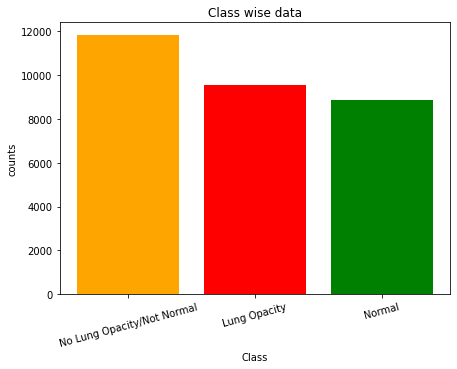

In [19]:
#plot the class wise classification 
plt.figure(figsize=(7,5),dpi=256)
fig,ax = plt.subplots(figsize=(7,5))
ax.bar(['No Lung Opacity/Not Normal','Lung Opacity','Normal'],mergedf['class'].value_counts().values,color=['orange','red','green'])
ax.tick_params(axis='x', rotation=15)
plt.xlabel('Class')
plt.ylabel('counts')
plt.title('Class wise data')
plt.show()

In [20]:
#read images dicom and get the info 
first_dicom_file = images_df[0]
first_dicom_file_path = os.path.join('train_images\\stage_2_train_images\\', first_dicom_file)
dcm = pdcm.dcmread(first_dicom_file_path)
dcm.fix_meta_info

<bound method Dataset.fix_meta_info of Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '

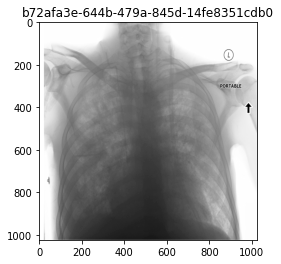

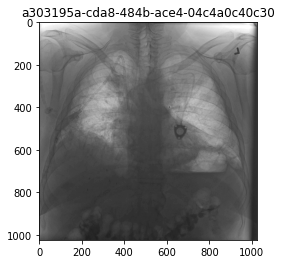

In [21]:
#just checking samples of train images 
pne_check = data_check['patientId'].sample(2)

for pni in pne_check:
    first_dicom_file_path = os.path.join('train_images\\stage_2_train_images\\', pni+'.dcm')
    dcm = pdcm.dcmread(first_dicom_file_path)
    plt.title(pni)
    plt.axis =0
    plt.imshow(dcm.pixel_array,cmap=plt.cm.binary) #used binary cmap
    plt.show()


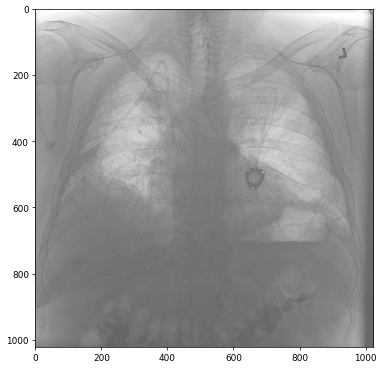

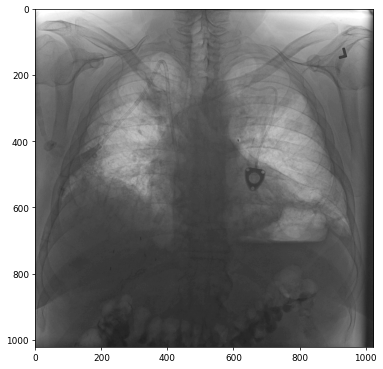

In [22]:
#try to check for the sharpanning images with sharpen filter 

image_array = dcm.pixel_array

kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

filtered_image =cv2.filter2D(image_array,-1,kernel)
plt.figure(figsize=(7,7),dpi=64)
plt.imshow((filtered_image),cmap=plt.cm.binary)
plt.show()
plt.figure(figsize=(7,7),dpi=64)
plt.imshow(dcm.pixel_array,cmap=plt.cm.binary)


In [23]:
def createfolderifnot(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f'path create {path}')

In [24]:
path_image_train = 'train_images\\images_jpg'
createfolderifnot(path_image_train)
path_image_train512 = 'train_images\\images_512_jpg'
createfolderifnot(path_image_train512)
path_image_train256 = 'train_images\\images_256_jpg'
createfolderifnot(path_image_train256)
path_image_train128 = 'train_images\\images_128_jpg'
createfolderifnot(path_image_train128)

In [25]:
info_df = mergedf.copy()
total_images = info_df['patientId'].unique()


In [27]:
info_df['AGE'] = 0
info_df['SEX'] = 0
info_df['ViewPosition']=''
info_df['BodyPart'] = ''
info_df['glcm_contrast'] = ''
info_df['glcm_homogeneity'] = ''
info_df['glcm_energy'] = ''
info_df['glcm_correlation'] = ''


In [28]:
## loop for the image to get meta data for age sex body part and view position
for i in total_images:
    path = f'train_images\\stage_2_train_images\\{i}.dcm'
    if os.path.isfile(path):
        first_dicom_file_path = os.path.join(path)
        dcm_read = pdcm.dcmread(first_dicom_file_path)
        img = Image.fromarray(dcm_read.pixel_array)
        img.save(f'{path_image_train}\\{i}.jpg')
        img2 = img.resize((512, 512))
        img2.save(f'{path_image_train512}\\{i}.jpg')
        img256 = img.resize((256, 256))
        img256.save(f'{path_image_train256}\\{i}.jpg')
        img128 = img.resize((128, 128))
        img128.save(f'{path_image_train128}\\{i}.jpg')
        image_array = np.array(img128)
    
        # Example: Thresholding to segment lung regions
        # threshold = -50  # Adjust threshold value based on DICOM pixel intensity range
        # lung_mask = image_array < threshold
        
        distances = [1, 2, 3]  # Adjust distances based on image resolution
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        glcm = graycomatrix(image_array.astype(np.uint8), distances, angles, symmetric=True, normed=True)
        # print(glcm)
        for il in info_df[info_df['patientId']== i].index:
            print(f'image done {il}')
            info_df.loc[il,'AGE'] = dcm_read.PatientAge
            info_df.loc[il,'SEX'] = 0 if dcm_read.PatientSex == 'F' else 1
            info_df.loc[il,'BodyPart'] =dcm_read.BodyPartExamined
            info_df.loc[il,'ViewPosition'] =dcm_read.ViewPosition
            info_df.loc[il,'glcm_contrast'] =  graycoprops(glcm, 'contrast').mean()
            info_df.loc[il,'glcm_homogeneity'] = graycoprops(glcm, 'homogeneity').mean()
            info_df.loc[il,'glcm_energy'] = graycoprops(glcm, 'energy').mean()
            info_df.loc[il,'glcm_correlation'] = graycoprops(glcm, 'correlation').mean()

    else:
        print('nofile found ',i)
    

image done 0
image done 1
image done 2
image done 3
image done 4
image done 6
image done 8
image done 9
image done 10
image done 12
image done 14
image done 15
image done 16
image done 17
image done 18
image done 20
image done 22
image done 24
image done 26
image done 27
image done 29
image done 31
image done 32
image done 33
image done 34
image done 36
image done 38
image done 39
image done 41
image done 43
image done 44
image done 45
image done 46
image done 48
image done 50
image done 51
image done 52
image done 54
image done 56
image done 57
image done 58
image done 59
image done 61
image done 63
image done 65
image done 67
image done 68
image done 69
image done 70
image done 71
image done 73
image done 75
image done 77
image done 79
image done 80
image done 81
image done 82
image done 83
image done 85
image done 87
image done 88
image done 89
image done 90
image done 91
image done 93
image done 95
image done 96
image done 97
image done 98
image done 99
image done 100
image done 10

In [29]:
info_df.to_csv('infodf.csv')

In [57]:
info_df = pd.read_csv('infodf.csv')
info_df = info_df[info_df.columns[1:]]
info_df


patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN   
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN   
2      00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN   
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN   
4      00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0   
...                                     ...    ...    ...    ...     ...   
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  185.0  298.0  228.0   379.0   
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba    NaN    NaN    NaN     NaN   
30224  c1f6b555-2eb1-4231-98f6-50a963976431    NaN    NaN    NaN     NaN   
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   

       Target  class  AGE  SEX ViewPosition BodyPart  glcm_contrast  \
0           0      2   51    0           PA    CHEST     240.363107   
1           0      2   48    0           PA    CHEST      52.810114   
2           0      2   19    1           AP    CHEST     220.881035   
3           0      0   28    1           PA    CHEST     406.426794   
4           1      1   32    0           AP    CHEST      86.499986   
...       ...    ...  ...  ...          ...      ...            ...   
30222       1      1   54    1           AP    CHEST     251.202459   
30223       0      0   46    0           PA    CHEST     139.894010   
30224       0      0   45    1           PA    CHEST     325.506092   
30225       1      1   72    0           AP    CHEST     198.700831   
30226       1      1   72    0           AP    CHEST     198.700831   

       glcm_homogeneity  glcm_energy  glcm_correlation  
0              0.221791     0.041201          0.977566  
1              0.333943     0.077472          0.983760  
2              0.200721     0.025836          0.968193  
3              0.165048     0.019650          0.954598  
4              0.236534     0.020687          0.986255  
...                 ...          ...               ...  
30222          0.243280     0.057668          0.932018  
30223          0.238966     0.074233          0.985241  
30224          0.212639     0.023197          0.924871  
30225          0.227273     0.023604          0.973146  
30226          0.227273     0.023604          0.973146  

[30227 rows x 15 columns]

In [58]:
glcmcol = [ 'glcm_contrast', 'glcm_homogeneity','glcm_energy', 'glcm_correlation']
for i in glcmcol:
    info_df[i] = pd.to_numeric(info_df[i])

info_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   patientId         30227 non-null  object 
 1   x                 9555 non-null   float64
 2   y                 9555 non-null   float64
 3   width             9555 non-null   float64
 4   height            9555 non-null   float64
 5   Target            30227 non-null  int64  
 6   class             30227 non-null  int64  
 7   AGE               30227 non-null  int64  
 8   SEX               30227 non-null  int64  
 9   ViewPosition      30227 non-null  object 
 10  BodyPart          30227 non-null  object 
 11  glcm_contrast     30227 non-null  float64
 12  glcm_homogeneity  30227 non-null  float64
 13  glcm_energy       30227 non-null  float64
 14  glcm_correlation  30227 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 3.5+ MB


In [59]:
info_df.describe(include='all')

patientId            x            y  \
count                                  30227  9555.000000  9555.000000   
unique                                 26684          NaN          NaN   
top     3239951b-6211-4290-b237-3d9ad17176db          NaN          NaN   
freq                                       4          NaN          NaN   
mean                                     NaN   394.047724   366.839560   
std                                      NaN   204.574172   148.940488   
min                                      NaN     2.000000     2.000000   
25%                                      NaN   207.000000   249.000000   
50%                                      NaN   324.000000   365.000000   
75%                                      NaN   594.000000   478.500000   
max                                      NaN   835.000000   881.000000   

              width       height        Target         class           AGE  \
count   9555.000000  9555.000000  30227.000000  30227.000000  30227.000000   
unique          NaN          NaN           NaN           NaN           NaN   
top             NaN          NaN           NaN           NaN           NaN   
freq            NaN          NaN           NaN           NaN           NaN   
mean     218.471376   329.269702      0.316108      1.098257     46.797764   
std       59.289475   157.750755      0.464963      0.821133     16.892940   
min       40.000000    45.000000      0.000000      0.000000      1.000000   
25%      177.000000   203.000000      0.000000      0.000000     34.000000   
50%      217.000000   298.000000      0.000000      1.000000     49.000000   
75%      259.000000   438.000000      1.000000      2.000000     59.000000   
max      528.000000   942.000000      1.000000      2.000000    155.000000   

                 SEX ViewPosition BodyPart  glcm_contrast  glcm_homogeneity  \
count   30227.000000        30227    30227   30227.000000      30227.000000   
unique           NaN            2        1            NaN               NaN   
top              NaN           AP    CHEST            NaN               NaN   
freq             NaN        15297    30227            NaN               NaN   
mean        0.569557          NaN      NaN     247.026187          0.229017   
std         0.495146          NaN      NaN     136.758147          0.052652   
min         0.000000          NaN      NaN      15.571242          0.091079   
25%         0.000000          NaN      NaN     143.653314          0.193911   
50%         1.000000          NaN      NaN     228.389563          0.222584   
75%         1.000000          NaN      NaN     321.095833          0.255714   
max         1.000000          NaN      NaN    1506.355794          0.733597   

         glcm_energy  glcm_correlation  
count   30227.000000      30227.000000  
unique           NaN               NaN  
top              NaN               NaN  
freq             NaN               NaN  
mean        0.041265          0.962661  
std         0.044948          0.017100  
min         0.012571          0.745418  
25%         0.022976          0.954354  
50%         0.028748          0.965842  
75%         0.041918          0.974290  
max         0.686796          0.996324

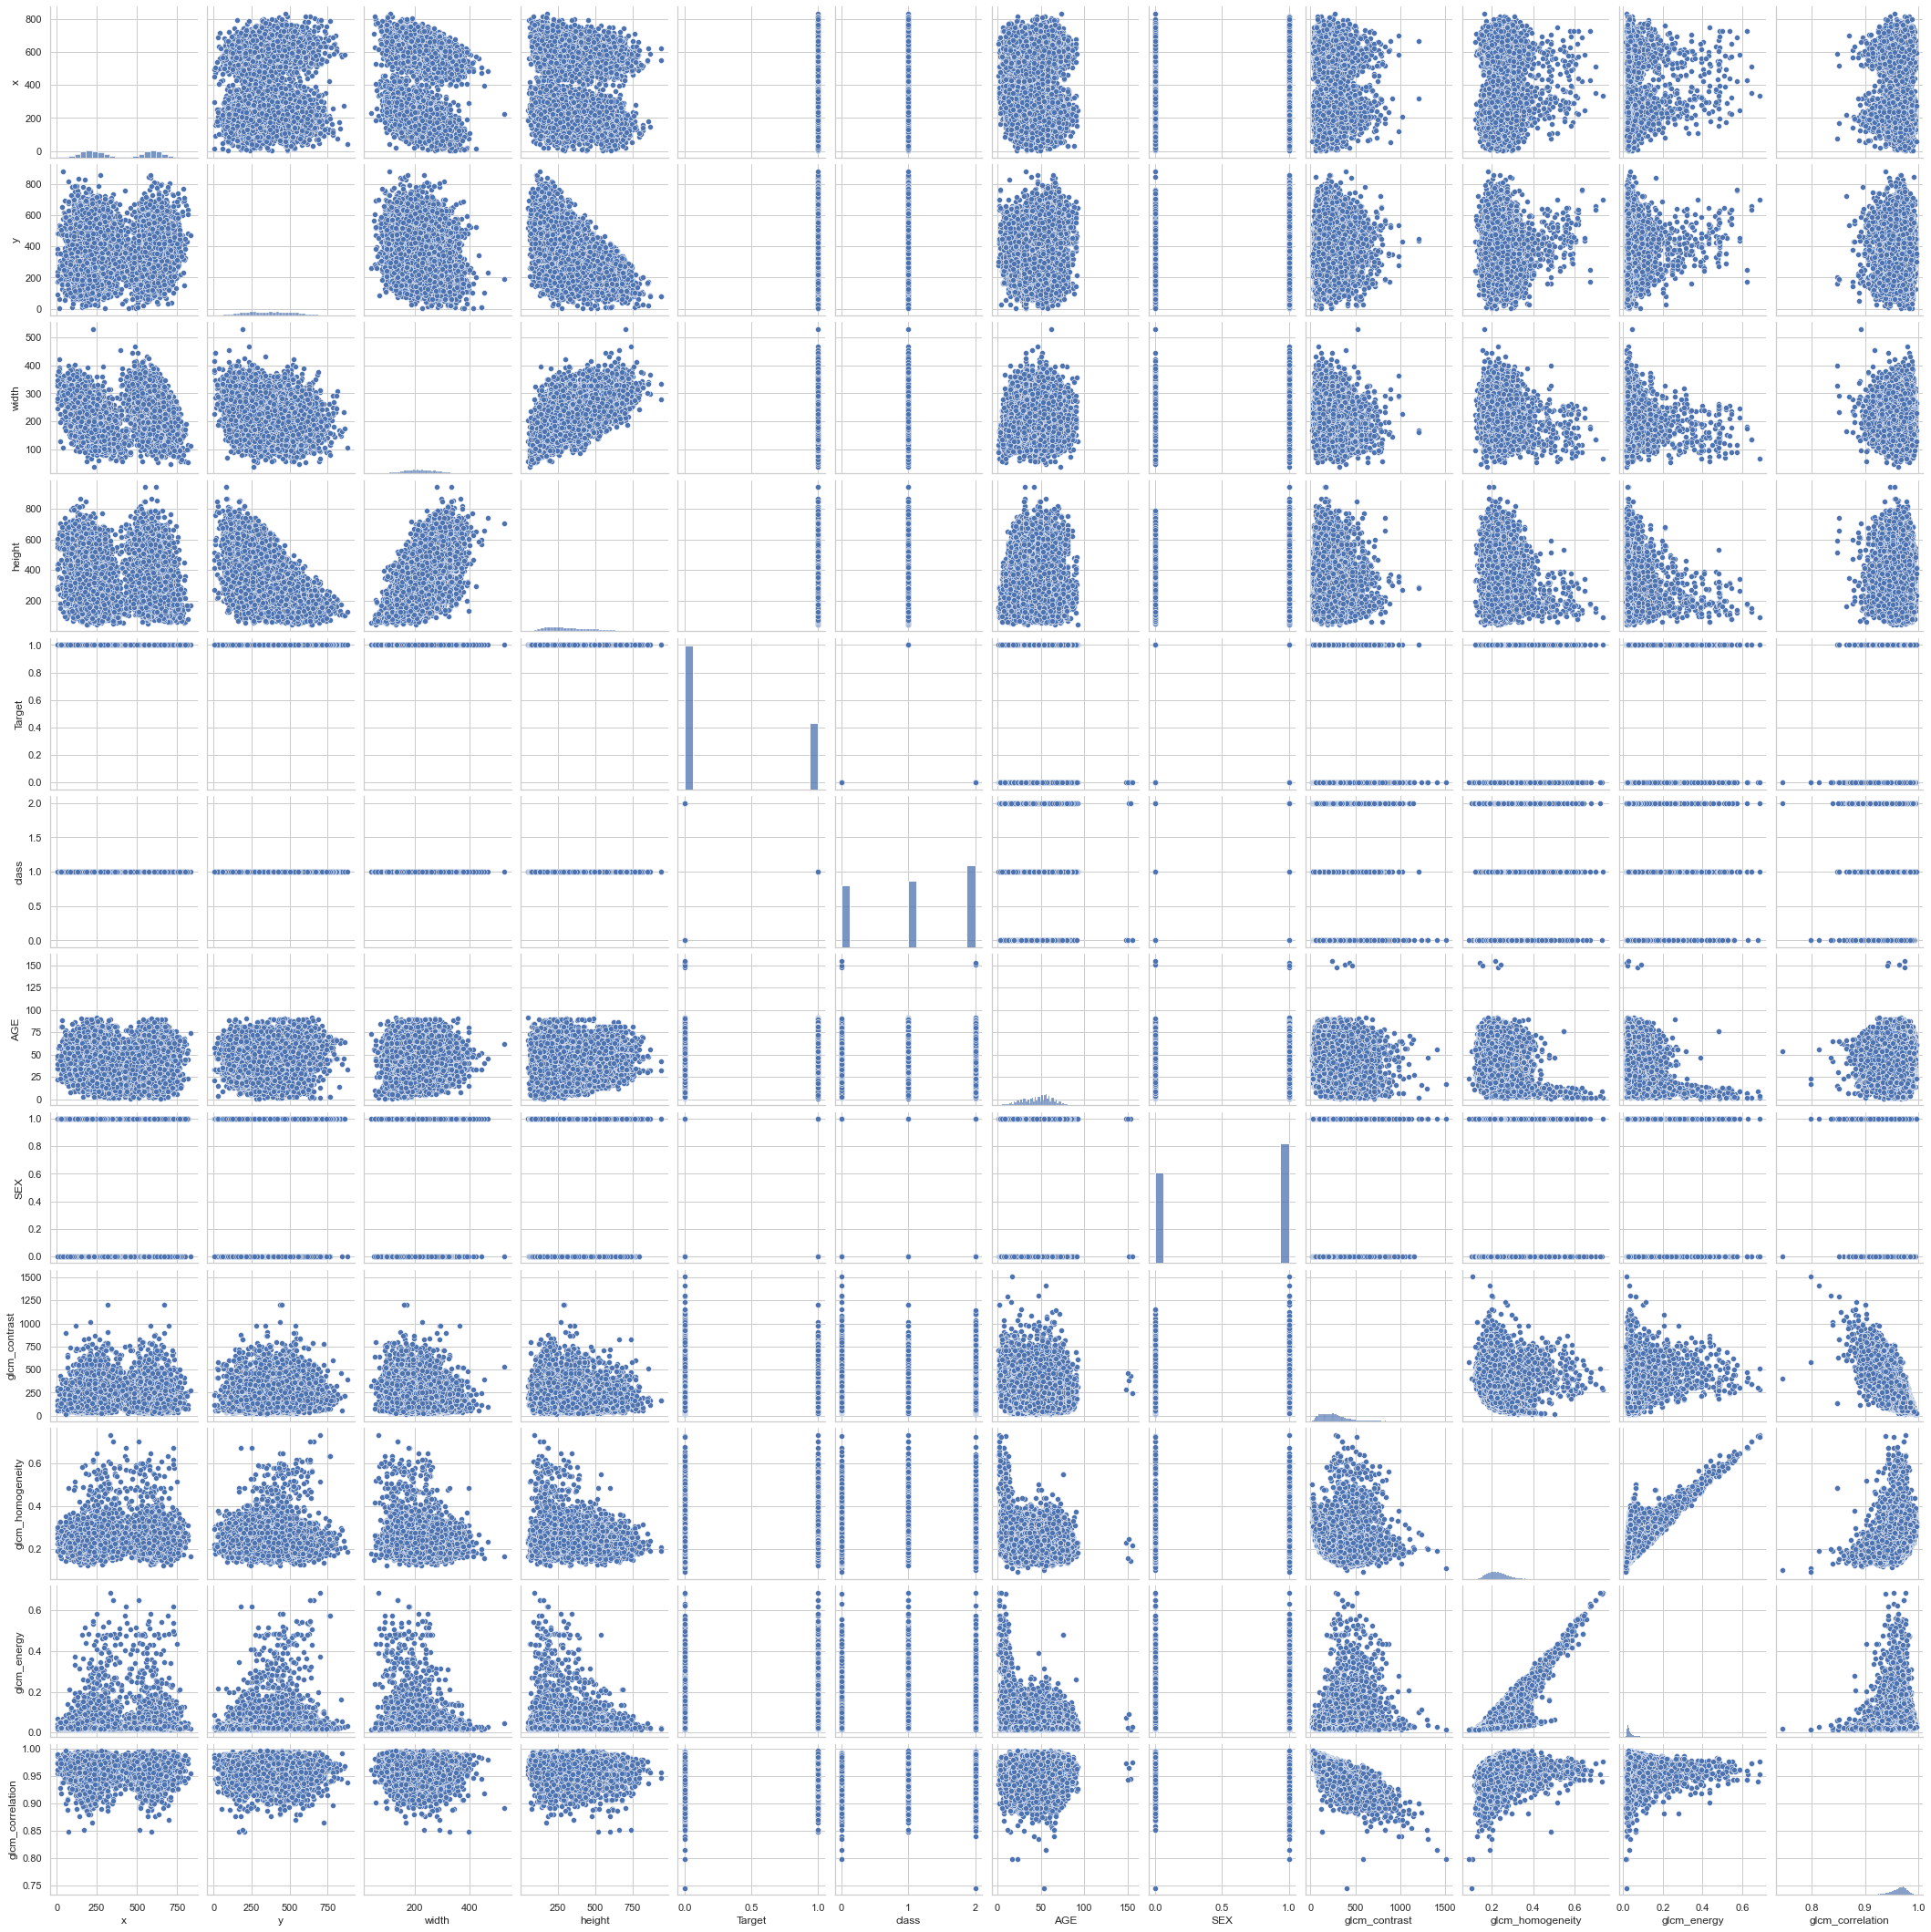

In [60]:
sns.pairplot(data=info_df)

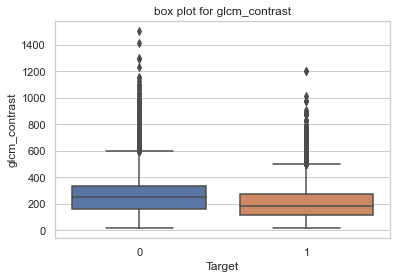

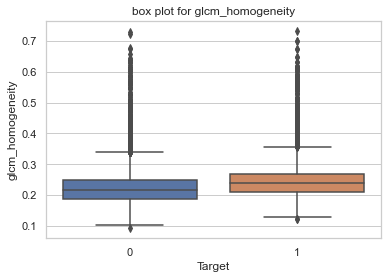

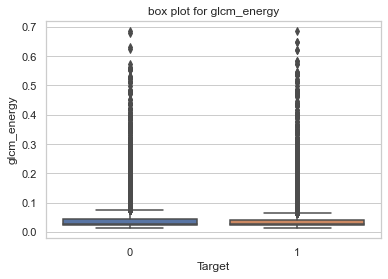

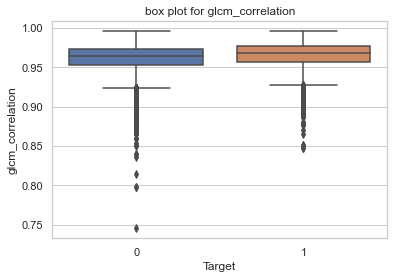

In [61]:
for i in glcmcol:
    plt.title(f'box plot for {i}')
    sns.boxplot(data=info_df,x='Target',y=i)
    plt.show()

<AxesSubplot:>

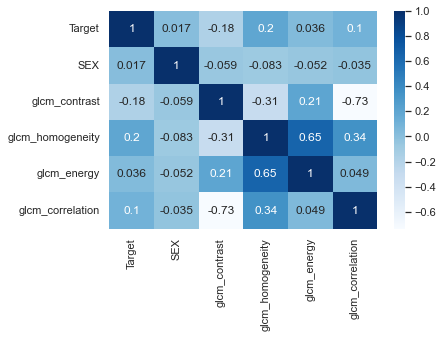

In [62]:
targetcols = ['Target','SEX','glcm_contrast', 'glcm_homogeneity','glcm_energy', 'glcm_correlation']
df_cor = info_df[targetcols]
sns.heatmap(data=df_cor.corr(),cmap=plt.cm.Blues,annot=True)

In [63]:
printwithinfoseparator(info_df['BodyPart'].value_counts(),'body part value uniqueness check')
printwithinfoseparator(info_df['ViewPosition'].value_counts(),'view position value uniqueness check')
printwithinfoseparator(info_df['SEX'].value_counts(),'Sex value uniqueness check')


--------====== body part value uniqueness check =====-----------
CHEST    30227
Name: BodyPart, dtype: int64
---------===========-----------
--------====== view position value uniqueness check =====-----------
AP    15297
PA    14930
Name: ViewPosition, dtype: int64
---------===========-----------
--------====== Sex value uniqueness check =====-----------
1    17216
0    13011
Name: SEX, dtype: int64
---------===========-----------


In [64]:
info_df['AGE'].describe()

count    30227.000000
mean        46.797764
std         16.892940
min          1.000000
25%         34.000000
50%         49.000000
75%         59.000000
max        155.000000
Name: AGE, dtype: float64

In [65]:
info_df_512 = info_df.copy()

In [66]:
size = 512
def calculatetheimageboundings(x):
    mainsize = 1024
    # print(x)
    if x > 0:
        divider = mainsize//size
        # print(divider)
        _x  = x//divider
        # print(_x)
        return _x

In [67]:
size=512
info_df_512['x'] = info_df_512['x'].apply(calculatetheimageboundings)
info_df_512['y'] = info_df_512['y'].apply(calculatetheimageboundings)
info_df_512['width'] = info_df_512['width'].apply(calculatetheimageboundings)
info_df_512['height'] = info_df_512['height'].apply(calculatetheimageboundings)

In [68]:
info_df_512

patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN   
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN   
2      00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN   
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN   
4      00436515-870c-4b36-a041-de91049b9ab4  132.0   76.0  106.0   189.0   
...                                     ...    ...    ...    ...     ...   
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8   92.0  149.0  114.0   189.0   
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba    NaN    NaN    NaN     NaN   
30224  c1f6b555-2eb1-4231-98f6-50a963976431    NaN    NaN    NaN     NaN   
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  285.0  196.0  130.0   172.0   
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  116.0  212.0  100.0   178.0   

       Target  class  AGE  SEX ViewPosition BodyPart  glcm_contrast  \
0           0      2   51    0           PA    CHEST     240.363107   
1           0      2   48    0           PA    CHEST      52.810114   
2           0      2   19    1           AP    CHEST     220.881035   
3           0      0   28    1           PA    CHEST     406.426794   
4           1      1   32    0           AP    CHEST      86.499986   
...       ...    ...  ...  ...          ...      ...            ...   
30222       1      1   54    1           AP    CHEST     251.202459   
30223       0      0   46    0           PA    CHEST     139.894010   
30224       0      0   45    1           PA    CHEST     325.506092   
30225       1      1   72    0           AP    CHEST     198.700831   
30226       1      1   72    0           AP    CHEST     198.700831   

       glcm_homogeneity  glcm_energy  glcm_correlation  
0              0.221791     0.041201          0.977566  
1              0.333943     0.077472          0.983760  
2              0.200721     0.025836          0.968193  
3              0.165048     0.019650          0.954598  
4              0.236534     0.020687          0.986255  
...                 ...          ...               ...  
30222          0.243280     0.057668          0.932018  
30223          0.238966     0.074233          0.985241  
30224          0.212639     0.023197          0.924871  
30225          0.227273     0.023604          0.973146  
30226          0.227273     0.023604          0.973146  

[30227 rows x 15 columns]

In [69]:


# function to draw bounding Box on images
def get_bb(imag,data_lab,patid):
  
  for i in range(len(data_lab)):
    if data_lab.iloc[i]['patientId']==patid and data_lab.iloc[i]['Target']==1:
      x= int(data_lab.iloc[i]['x'])
      y= int(data_lab.iloc[i]['y'])                                                     
      w= int(data_lab.iloc[i]['width'])
      h= int(data_lab.iloc[i]['height'])
      bb=cv2.rectangle(imag,(x,y),(x+w,y+h),(255,0,0),3)
      plt.imshow(bb,cmap=plt.cm.binary)
      
      
    elif data_lab.iloc[i]['patientId']==patid and data_lab.iloc[i]['Target']==0:
      plt.imshow(imag,cmap=plt.cm.binary) 
      
  plt.show()

In [70]:
patid_ref = info_df[info_df['Target'] == 1]['patientId'].sample(5)
patid_ref

21226    c10053b8-7bc8-4d8f-99f0-92d86a97ee2e
19774    b6db3041-1554-43ef-baca-58733b6717d6
12546    7fa10f67-8c38-4027-b7f6-50887f85ad43
17457    a6c364d2-b2d6-4b0b-a439-40b992ff65c7
14685    90b2b94e-efa8-4ff7-98e1-86ea3e33b575
Name: patientId, dtype: object

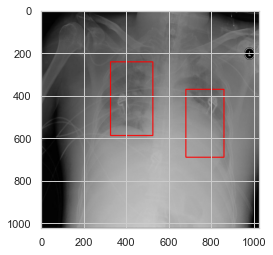

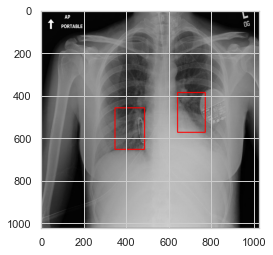

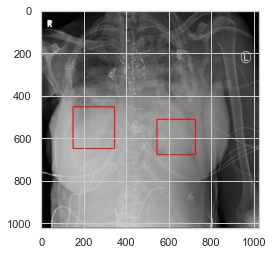

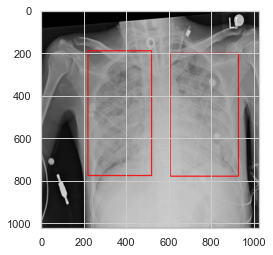

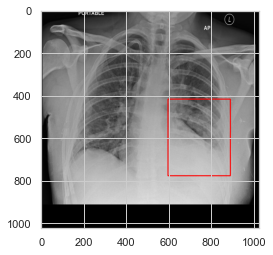

In [71]:
for i in patid_ref: 
    img1= cv2.imread(f'train_images\images_jpg\{i}.jpg')
    get_bb(img1,info_df,i)

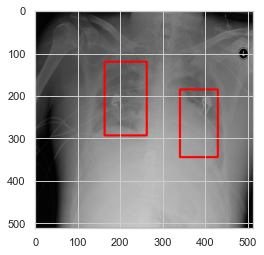

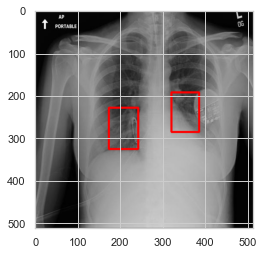

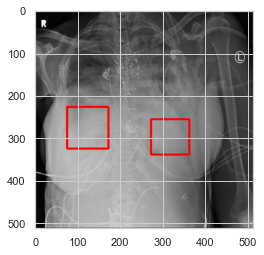

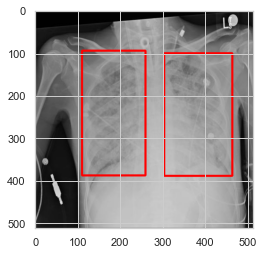

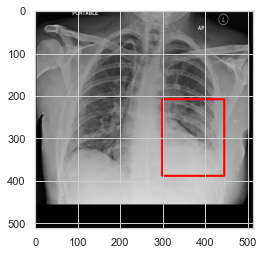

In [72]:
for i in patid_ref: 
    img1= cv2.imread(f'train_images\images_512_jpg\{i}.jpg')
    get_bb(img1,info_df_512,i)

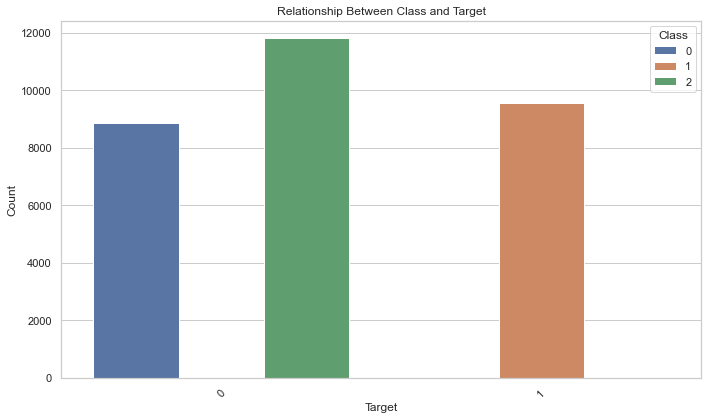

In [73]:
sns.set(style="whitegrid")

# Create the countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='Target', hue='class', data=info_df)
plt.title('Relationship Between Class and Target')
plt.xlabel('Target')
plt.ylabel('Count')
plt.legend(title='Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


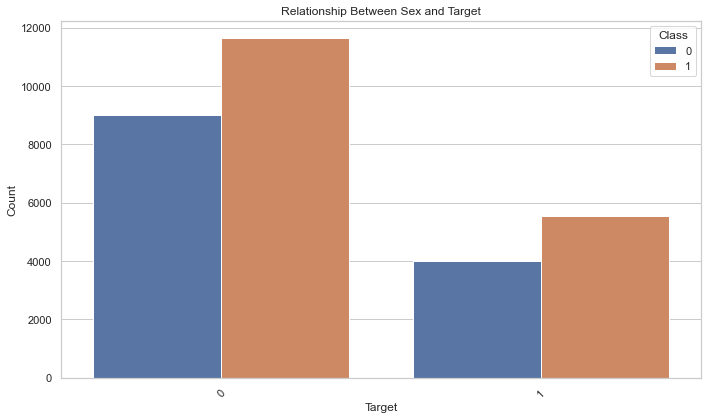

In [74]:
sns.set(style="whitegrid")

# Create the countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='Target', hue='SEX', data=info_df)
plt.title('Relationship Between Sex and Target')
plt.xlabel('Target')
plt.ylabel('Count')
plt.legend(title='Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\JAYPAT~1\AppData\Local\Temp/ipykernel_1632/2878436323.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=lung_opacity_data, x='x', shade=True, color='blue')
C:\Users\JAYPAT~1\AppData\Local\Temp/ipykernel_1632/2878436323.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=lung_opacity_data, x='y', shade=True, color='green')
C:\Users\JAYPAT~1\AppData\Local\Temp/ipykernel_1632/2878436323.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=lung_opacity_data, x='width', shade=True, color='orange')
C:\Users\JAYPAT~1\AppData\Local\Temp/ipykernel_1632/2878436323.py:20: FutureWarning: 

`shade` is now d

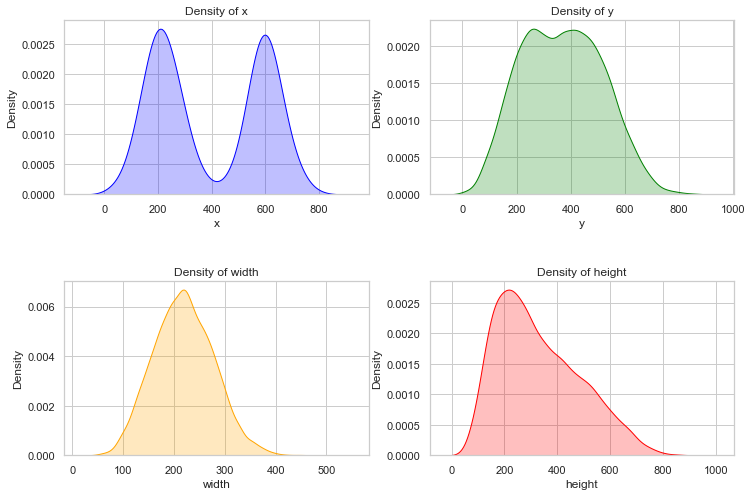

In [75]:
lung_opacity_data = info_df[info_df['Target'] == 1]

# Plotting
plt.figure(figsize=(12, 8))
plt.subplots_adjust(hspace=0.5)

plt.subplot(2, 2, 1)
sns.kdeplot(data=lung_opacity_data, x='x', shade=True, color='blue')
plt.title('Density of x')

plt.subplot(2, 2, 2)
sns.kdeplot(data=lung_opacity_data, x='y', shade=True, color='green')
plt.title('Density of y')

plt.subplot(2, 2, 3)
sns.kdeplot(data=lung_opacity_data, x='width', shade=True, color='orange')
plt.title('Density of width')

plt.subplot(2, 2, 4)
sns.kdeplot(data=lung_opacity_data, x='height', shade=True, color='red')
plt.title('Density of height')

plt.show()

C:\Users\JAYPAT~1\AppData\Local\Temp/ipykernel_1632/2122389849.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  info_df.hist(ax=ax)


array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>,
        <AxesSubplot:title={'center':'width'}>],
       [<AxesSubplot:title={'center':'height'}>,
        <AxesSubplot:title={'center':'Target'}>,
        <AxesSubplot:title={'center':'class'}>],
       [<AxesSubplot:title={'center':'AGE'}>,
        <AxesSubplot:title={'center':'SEX'}>,
        <AxesSubplot:title={'center':'glcm_contrast'}>],
       [<AxesSubplot:title={'center':'glcm_homogeneity'}>,
        <AxesSubplot:title={'center':'glcm_energy'}>,
        <AxesSubplot:title={'center':'glcm_correlation'}>]], dtype=object)

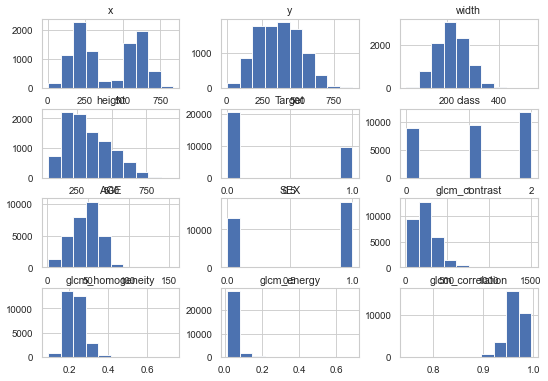

In [76]:
ax= plt.figure(figsize=(10,7),dpi=64)
info_df.hist(ax=ax)

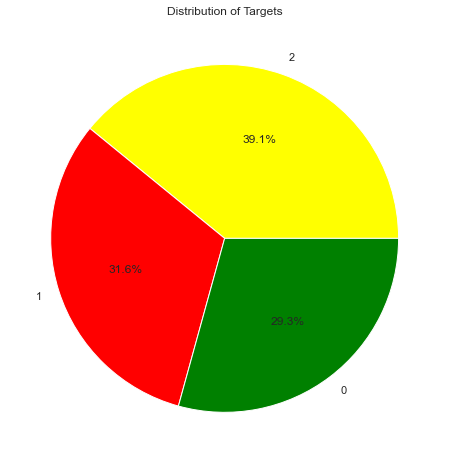

In [77]:
# Assuming df is your DataFrame containing the 'Target' column
target_counts = info_df['class'].value_counts()

# Plotting the distribution as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', colors=['yellow', 'red','green'])
plt.title('Distribution of Targets')
plt.show()

<AxesSubplot:xlabel='x', ylabel='width'>

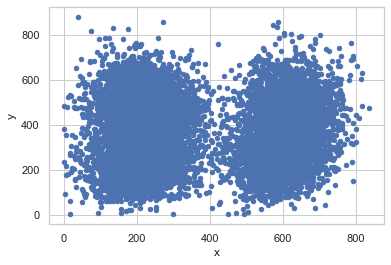

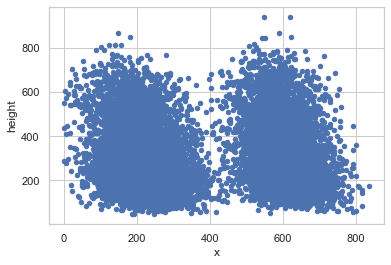

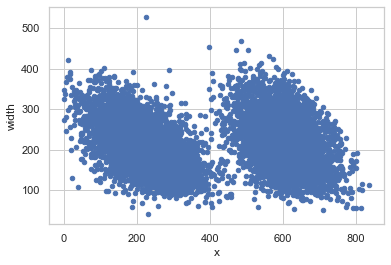

In [78]:
pos_bbox = info_df.query('Target==1')
pos_bbox.plot.scatter(x='x', y='y')
pos_bbox.plot.scatter(x='x', y='height')
pos_bbox.plot.scatter(x='x', y='width')

<Figure size 144x144 with 0 Axes>

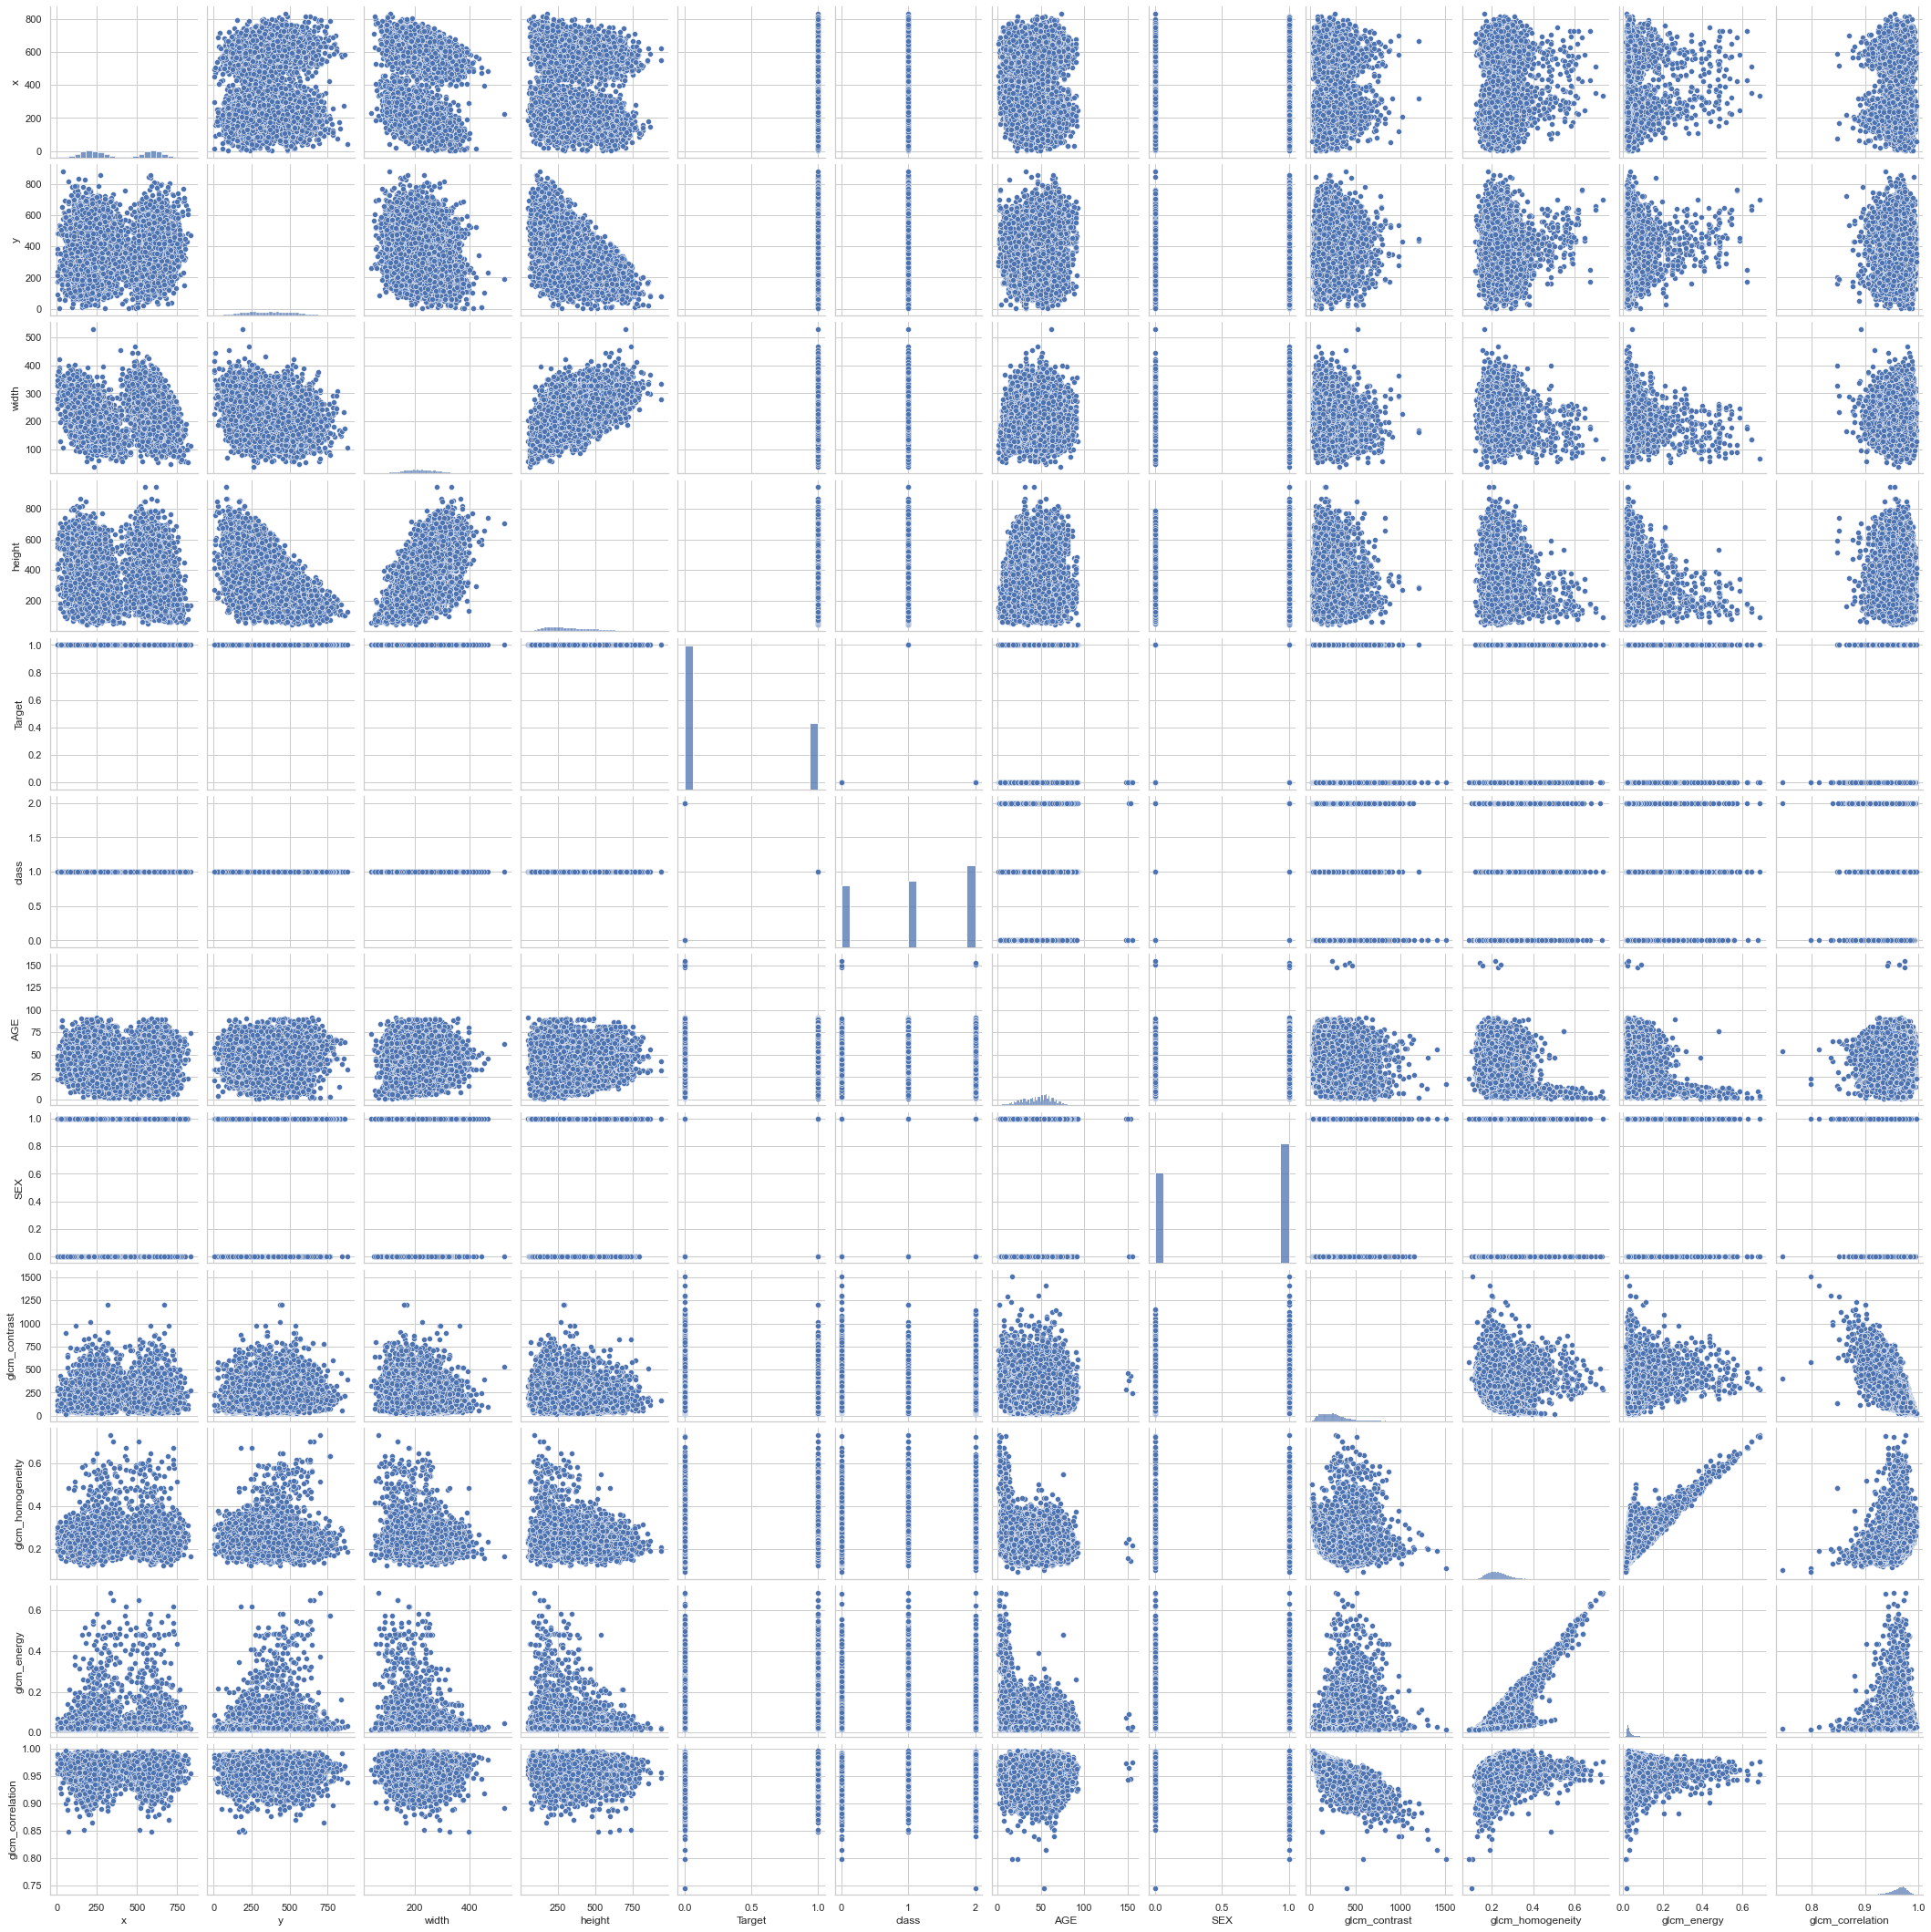

In [79]:
plt.figure(figsize=(2,2))
sns.pairplot(data=info_df)

In [80]:
def agetocatagory(age):
    age = int(age)
    if age >= 1 and age <= 13:
        return 'child'
    elif age >= 14 and age <=19:
        return 'teenage'
    elif age >=20 and age <=45:
        return 'Young'
    elif age >=46 and age <=60:
        return 'old'
    elif age >=61:
        return 'vold'


In [81]:
info_df['agecat'] =''

info_df['agecat'] = info_df['AGE'].apply(agetocatagory)

In [82]:
#for checkign based on target and sex wise age catagory
info_df.groupby(['Target','SEX'])['agecat'].value_counts()

Target  SEX  agecat 
0       0    Young      3410
             old        3240
             vold       1916
             teenage     252
             child       198
        1    old        4109
             Young      4009
             vold       2802
             teenage     451
             child       285
1       0    Young      1488
             old        1405
             vold        812
             child       147
             teenage     143
        1    Young      2246
             old        1735
             vold       1122
             teenage     248
             child       209
Name: agecat, dtype: int64

Text(0.5, 1.0, 'Relationship Between age catagory and Target')

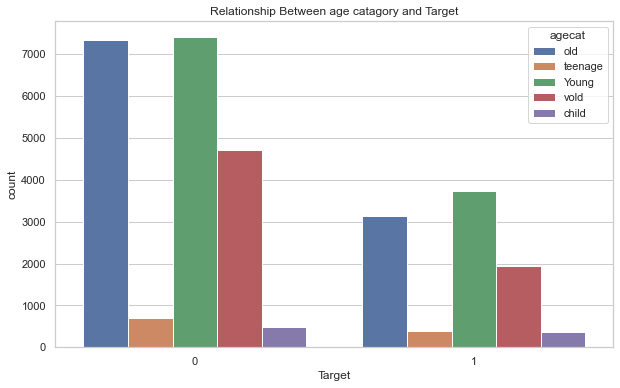

In [83]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Target', hue='agecat', data=info_df)
plt.title('Relationship Between age catagory and Target')

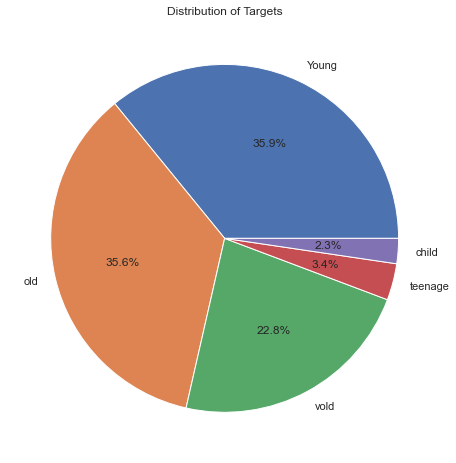

In [84]:
# Assuming df is your DataFrame containing the 'Target' column
target_counts = info_df.query('Target ==0')['agecat'].value_counts()

# Plotting the distribution as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Targets')
plt.show()

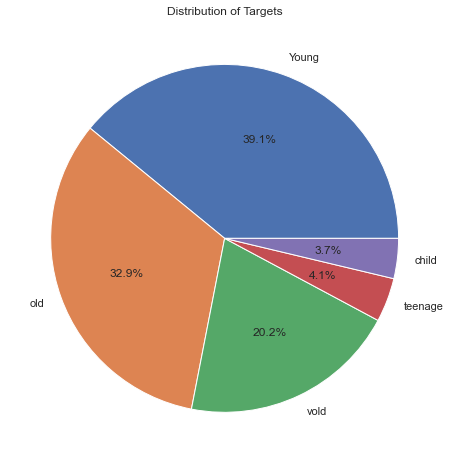

In [85]:
target_counts = info_df.query('Target ==1')['agecat'].value_counts()

# Plotting the distribution as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Targets')
plt.show()

Model Building for classification

In [86]:
size = 256
info_df_256 = info_df.copy()

In [87]:
info_df_256['x'] = info_df_256['x'].apply(calculatetheimageboundings)
info_df_256['y'] = info_df_256['y'].apply(calculatetheimageboundings)
info_df_256['width'] = info_df_256['width'].apply(calculatetheimageboundings)
info_df_256['height'] = info_df_256['height'].apply(calculatetheimageboundings)
info_df_256

patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN   
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN   
2      00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN   
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN   
4      00436515-870c-4b36-a041-de91049b9ab4   66.0   38.0   53.0    94.0   
...                                     ...    ...    ...    ...     ...   
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8   46.0   74.0   57.0    94.0   
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba    NaN    NaN    NaN     NaN   
30224  c1f6b555-2eb1-4231-98f6-50a963976431    NaN    NaN    NaN     NaN   
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  142.0   98.0   65.0    86.0   
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a   58.0  106.0   50.0    89.0   

       Target  class  AGE  SEX ViewPosition BodyPart  glcm_contrast  \
0           0      2   51    0           PA    CHEST     240.363107   
1           0      2   48    0           PA    CHEST      52.810114   
2           0      2   19    1           AP    CHEST     220.881035   
3           0      0   28    1           PA    CHEST     406.426794   
4           1      1   32    0           AP    CHEST      86.499986   
...       ...    ...  ...  ...          ...      ...            ...   
30222       1      1   54    1           AP    CHEST     251.202459   
30223       0      0   46    0           PA    CHEST     139.894010   
30224       0      0   45    1           PA    CHEST     325.506092   
30225       1      1   72    0           AP    CHEST     198.700831   
30226       1      1   72    0           AP    CHEST     198.700831   

       glcm_homogeneity  glcm_energy  glcm_correlation   agecat  
0              0.221791     0.041201          0.977566      old  
1              0.333943     0.077472          0.983760      old  
2              0.200721     0.025836          0.968193  teenage  
3              0.165048     0.019650          0.954598    Young  
4              0.236534     0.020687          0.986255    Young  
...                 ...          ...               ...      ...  
30222          0.243280     0.057668          0.932018      old  
30223          0.238966     0.074233          0.985241      old  
30224          0.212639     0.023197          0.924871    Young  
30225          0.227273     0.023604          0.973146     vold  
30226          0.227273     0.023604          0.973146     vold  

[30227 rows x 16 columns]

In [104]:
#for getting just 1000 images from each classes
target_not_phe = info_df_256[info_df_256['class']==0].sample(1000)
target_not_phe_not_op =  info_df_256[info_df_256['class']==2].sample(1000)
target_phe =info_df_256[info_df_256['class']==1].sample(1000)


In [105]:
combine_model_df_1k = pd.concat([target_not_phe,target_phe,target_not_phe_not_op],axis=0)

combine_model_df_1k.reset_index(drop=True)
combine_model_df_1k

patientId   x   y  width  height  Target  \
2774   340e5ce5-5845-4c7d-be4d-a646c7e5c4ed NaN NaN    NaN     NaN       0   
7620   5871b176-cee8-4b9b-80e0-a6a4cf36d1b6 NaN NaN    NaN     NaN       0   
23918  d70cf6a3-da4b-4ecf-a93a-62eaa70312d5 NaN NaN    NaN     NaN       0   
12153  7c897de5-15ff-405c-a77c-c588e7e151c0 NaN NaN    NaN     NaN       0   
26756  ee4bf94c-e2eb-4ebf-9246-f5f611cd77d8 NaN NaN    NaN     NaN       0   
...                                     ...  ..  ..    ...     ...     ...   
10413  6ef0044f-2fe6-435f-b058-11d2c05c4f81 NaN NaN    NaN     NaN       0   
1535   16d84b55-672c-431b-932e-a2d790ed591a NaN NaN    NaN     NaN       0   
17536  a75a84bc-8918-4cbd-b8b0-7ccfa8f8e3d2 NaN NaN    NaN     NaN       0   
22792  cd998117-d583-4316-b9b0-a2a67403ac09 NaN NaN    NaN     NaN       0   
12405  7ea6a920-a1ad-4cf1-91d5-a6634708b12c NaN NaN    NaN     NaN       0   

       class  AGE  SEX ViewPosition BodyPart  glcm_contrast  glcm_homogeneity  \
2774       0   23    1           PA    CHEST     183.368126          0.223974   
7620       0   35    1           PA    CHEST     271.839518          0.188084   
23918      0   46    1           AP    CHEST     156.942711          0.211622   
12153      0   76    1           PA    CHEST      56.795524          0.289655   
26756      0   59    1           PA    CHEST     228.136159          0.170099   
...      ...  ...  ...          ...      ...            ...               ...   
10413      2    7    0           AP    CHEST     742.363814          0.391316   
1535       2   56    1           AP    CHEST     297.546077          0.272186   
17536      2   42    1           AP    CHEST     206.591236          0.221989   
22792      2   38    0           PA    CHEST     372.123037          0.171904   
12405      2   69    0           AP    CHEST     129.375030          0.247923   

       glcm_energy  glcm_correlation agecat  
2774      0.042711          0.981042  Young  
7620      0.030167          0.969902  Young  
23918     0.028610          0.966852    old  
12153     0.036799          0.967289   vold  
26756     0.017896          0.968200    old  
...            ...               ...    ...  
10413     0.307867          0.932430  child  
1535      0.066064          0.959898    old  
17536     0.022661          0.960174  Young  
22792     0.021588          0.958739  Young  
12405     0.044306          0.973732   vold  

[3000 rows x 16 columns]

In [106]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D ,MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Assuming combine_model_df_1k contains the dataset with patientId and corresponding labels

# Define image dimensions and batch size
img_width, img_height = 256, 256
batch_size = 32

# Define the directory where the images are stored
image_directory = 'train_images/images_256_jpg'

# Convert numerical class labels to string representations
combine_model_df_1k['class'] = combine_model_df_1k['class'].astype(str)
combine_model_df_1k['patientId'] = combine_model_df_1k['patientId'] + '.jpg'
# Split the dataset into training and validation sets
train_df, val_df = train_test_split(combine_model_df_1k, test_size=0.2, random_state=77)
epocs_count = 25

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_directory,
    x_col="patientId",  # Use the column name for file paths
    y_col="class",      # Use the column name for labels
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_directory,
    x_col="patientId",  # Use the column name for file paths
    y_col="class",      # Use the column name for labels
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)



model_cnn_1 = Sequential()
model_cnn_1.add(Conv2D(9,(3,3),activation='relu',input_shape = (img_width,img_height,1)))
model_cnn_1.add(MaxPooling2D((2,2)))

model_cnn_1.add(Conv2D(16,(3,3),activation='relu'))
model_cnn_1.add(MaxPooling2D((2,2)))

model_cnn_1.add(Conv2D(32,(3,3),activation='relu'))
model_cnn_1.add(MaxPooling2D((2,2)))

# model_cnn_1.add(GlobalAveragePooling2D())

model_cnn_1.add(Flatten())

model_cnn_1.add(Dense(128,activation='relu'))
model_cnn_1.add(Dropout(0.4))

model_cnn_1.add(Dense(64,activation='relu'))
model_cnn_1.add(Dropout(0.5))

model_cnn_1.add(Dense(3,activation='softmax'))

# Compile the model_cnn_1
model_cnn_1.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class classification
              metrics=['accuracy'],)

# Define callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

# Train the model
history = model_cnn_1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epocs_count,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint, early_stopping]
)


Found 1920 validated image filenames belonging to 3 classes.
Found 120 validated image filenames belonging to 3 classes.
Epoch 1/25
60/60 [==============================] - ETA: 0s - loss: 1.1483 - accuracy: 0.3568
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model.h5
60/60 [==============================] - 12s 189ms/step - loss: 1.1483 - accuracy: 0.3568 - val_loss: 1.0650 - val_accuracy: 0.5000
Epoch 2/25
60/60 [==============================] - ETA: 0s - loss: 1.0080 - accuracy: 0.4760
Epoch 2: val_accuracy improved from 0.50000 to 0.54167, saving model to best_model.h5
60/60 [==============================] - 3s 53ms/step - loss: 1.0080 - accuracy: 0.4760 - val_loss: 0.9844 - val_accuracy: 0.5417
Epoch 3/25
60/60 [==============================] - ETA: 0s - loss: 0.9541 - accuracy: 0.5307
Epoch 3: val_accuracy improved from 0.54167 to 0.55208, saving model to best_model.h5
60/60 [==============================] - 3s 53ms/step - loss: 0.9541 - accuracy:

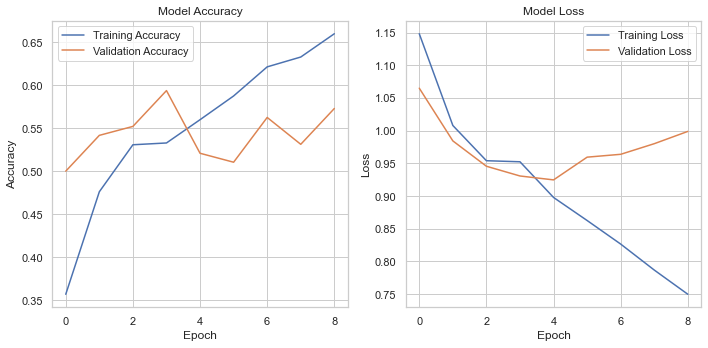

In [107]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create separate plots for accuracy and loss
plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(121)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(122)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [108]:
#for getting just 2000 images from each classes
target_not_phe = info_df_256[info_df_256['class']==0].sample(2000)
target_not_phe_not_op =  info_df_256[info_df_256['class']==2].sample(2000)
target_phe =info_df_256[info_df_256['class']==1].sample(2000)


In [109]:
combine_model_df_2k = pd.concat([target_not_phe,target_phe,target_not_phe_not_op],axis=0)
combine_model_df_2k.reset_index(drop=True)
combine_model_df_2k

patientId   x   y  width  height  Target  \
1775   18a5c559-5563-47e2-b26a-8b20f7250ab0 NaN NaN    NaN     NaN       0   
25981  e8214150-a9bb-47f3-99ab-76724ce4af2b NaN NaN    NaN     NaN       0   
25070  e0dc88d8-9318-4d9c-8c97-e0d6cecd8da9 NaN NaN    NaN     NaN       0   
25404  e3a72ca3-6dfe-4cfa-98a7-7eb566ff13ed NaN NaN    NaN     NaN       0   
26640  ed369fe4-b5e2-4ac4-8bef-ac7f5e18042b NaN NaN    NaN     NaN       0   
...                                     ...  ..  ..    ...     ...     ...   
763    0a23debc-fa30-486f-9555-750be017ae75 NaN NaN    NaN     NaN       0   
26281  eaaee470-cf44-4d79-a5f5-4e8b642fc999 NaN NaN    NaN     NaN       0   
5346   462a48b2-bcf4-486b-b082-75c91b9f1fb0 NaN NaN    NaN     NaN       0   
4249   3d9fe022-f01e-4685-893c-6f6f6eac2fa1 NaN NaN    NaN     NaN       0   
10241  6da20c13-b4ce-4009-af02-191262a92791 NaN NaN    NaN     NaN       0   

       class  AGE  SEX ViewPosition BodyPart  glcm_contrast  glcm_homogeneity  \
1775       0   27    1           PA    CHEST      76.340220          0.276846   
25981      0   58    1           PA    CHEST     227.217347          0.182679   
25070      0   59    1           PA    CHEST     185.424603          0.200336   
25404      0   41    1           PA    CHEST     247.851294          0.204559   
26640      0   12    1           AP    CHEST     264.433074          0.272203   
...      ...  ...  ...          ...      ...            ...               ...   
763        2   47    1           PA    CHEST     363.677512          0.160608   
26281      2   24    1           AP    CHEST      70.985622          0.279741   
5346       2   19    1           AP    CHEST     209.637471          0.240531   
4249       2   20    0           PA    CHEST     164.854973          0.259244   
10241      2   42    0           PA    CHEST     221.568034          0.205700   

       glcm_energy  glcm_correlation   agecat  
1775      0.041549          0.969491    Young  
25981     0.037458          0.974232      old  
25070     0.021099          0.966217      old  
25404     0.020587          0.966127    Young  
26640     0.092705          0.970542    child  
...            ...               ...      ...  
763       0.016582          0.954540      old  
26281     0.043673          0.982625    Young  
5346      0.064383          0.968633  teenage  
4249      0.045919          0.957367    Young  
10241     0.027079          0.954955    Young  

[6000 rows x 16 columns]

In [110]:
combine_model_df_2k['class'] = combine_model_df_2k['class'].astype(str)
combine_model_df_2k['patientId'] = combine_model_df_2k['patientId'] + '.jpg'
# Split the dataset into training and validation sets
train_df2, val_df2 = train_test_split(combine_model_df_2k, test_size=0.2, random_state=77)
epocs_count = 30

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df2,
    directory=image_directory,
    x_col="patientId",  # Use the column name for file paths
    y_col="class",      # Use the column name for labels
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=val_df2,
    directory=image_directory,
    x_col="patientId",  # Use the column name for file paths
    y_col="class",      # Use the column name for labels
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)



model_cnn_2_k256 = Sequential()
model_cnn_2_k256.add(Conv2D(9,(3,3),activation='relu',input_shape = (img_width,img_height,1)))
model_cnn_2_k256.add(MaxPooling2D((2,2)))

model_cnn_2_k256.add(Conv2D(16,(3,3),activation='relu'))
model_cnn_2_k256.add(MaxPooling2D((2,2)))

model_cnn_2_k256.add(Conv2D(8,(3,3),activation='relu'))
model_cnn_2_k256.add(MaxPooling2D((2,2)))


model_cnn_2_k256.add(Flatten())

model_cnn_2_k256.add(Dense(64,activation='relu'))
model_cnn_2_k256.add(Dropout(0.5))

model_cnn_2_k256.add(Dense(16,activation='relu'))

model_cnn_2_k256.add(Dense(3,activation='softmax'))

# Compile the model_cnn_2_k256
model_cnn_2_k256.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class classification
              metrics=['accuracy'],)

# Define callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, restore_best_weights=True)

# Train the model
history = model_cnn_2_k256.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epocs_count,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint, early_stopping]
)

Found 3840 validated image filenames belonging to 3 classes.
Found 240 validated image filenames belonging to 3 classes.
Epoch 1/30
120/120 [==============================] - ETA: 0s - loss: 1.0063 - accuracy: 0.4891
Epoch 1: val_accuracy improved from -inf to 0.54911, saving model to best_model.h5
120/120 [==============================] - 21s 173ms/step - loss: 1.0063 - accuracy: 0.4891 - val_loss: 0.8915 - val_accuracy: 0.5491
Epoch 2/30
120/120 [==============================] - ETA: 0s - loss: 0.9204 - accuracy: 0.5549
Epoch 2: val_accuracy improved from 0.54911 to 0.63839, saving model to best_model.h5
120/120 [==============================] - 6s 47ms/step - loss: 0.9204 - accuracy: 0.5549 - val_loss: 0.7900 - val_accuracy: 0.6384
Epoch 3/30
120/120 [==============================] - ETA: 0s - loss: 0.8894 - accuracy: 0.5701
Epoch 3: val_accuracy did not improve from 0.63839
120/120 [==============================] - 6s 47ms/step - loss: 0.8894 - accuracy: 0.5701 - val_loss: 0.8

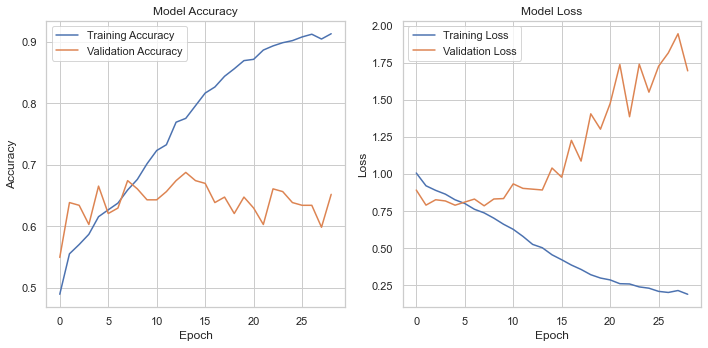

In [111]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create separate plots for accuracy and loss
plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(121)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(122)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [112]:
#for getting just 3000 images from each classes
target_not_phe = info_df_256[info_df_256['class']==0].sample(3000)
target_not_phe_not_op =  info_df_256[info_df_256['class']==2].sample(3000)
target_phe =info_df_256[info_df_256['class']==1].sample(3000)



combine_model_df_3k = pd.concat([target_not_phe,target_phe,target_not_phe_not_op],axis=0)
combine_model_df_3k.reset_index(drop=True)
combine_model_df_3k

patientId   x   y  width  height  Target  \
16289  9de81172-a002-46fc-b17c-8701f04c2647 NaN NaN    NaN     NaN       0   
15623  987237ff-671d-4142-93de-64036ccc6d8d NaN NaN    NaN     NaN       0   
10550  700dda66-d2a5-4898-8f6e-78ef63cbd2a3 NaN NaN    NaN     NaN       0   
25973  e811705a-0486-406a-aa0b-3c5ea99e2b1b NaN NaN    NaN     NaN       0   
15155  947e8c14-5f0c-4ac6-b6e8-cd1d06bfe1eb NaN NaN    NaN     NaN       0   
...                                     ...  ..  ..    ...     ...     ...   
12777  81a02f7b-228e-4b15-a0ba-21df6ae131ef NaN NaN    NaN     NaN       0   
20744  bd04fa63-5ecd-42da-bf2f-6214896bfc3e NaN NaN    NaN     NaN       0   
29349  12b8f793-1aad-426a-b116-5508be9b41a3 NaN NaN    NaN     NaN       0   
2259   2e776901-d47c-4d8e-9b8c-04587230ef92 NaN NaN    NaN     NaN       0   
14220  8d0c5b73-145f-47f1-8e50-563b44e4cf7b NaN NaN    NaN     NaN       0   

       class  AGE  SEX ViewPosition BodyPart  glcm_contrast  glcm_homogeneity  \
16289      0   47    0           PA    CHEST     605.074205          0.320357   
15623      0   46    1           AP    CHEST     159.388366          0.214131   
10550      0   51    0           PA    CHEST     484.081672          0.178203   
25973      0   58    0           PA    CHEST      98.155896          0.253060   
15155      0   43    1           PA    CHEST     134.330894          0.218163   
...      ...  ...  ...          ...      ...            ...               ...   
12777      2   64    0           PA    CHEST     192.862565          0.202584   
20744      2   65    1           PA    CHEST     425.011206          0.234750   
29349      2   30    1           AP    CHEST     102.990498          0.239806   
2259       2   59    0           AP    CHEST     133.688903          0.255747   
14220      2   48    1           PA    CHEST     211.343779          0.180150   

       glcm_energy  glcm_correlation agecat  
16289     0.137987          0.946489    old  
15623     0.027863          0.964438    old  
10550     0.019940          0.911100    old  
25973     0.029793          0.966974    old  
15155     0.025026          0.960076  Young  
...            ...               ...    ...  
12777     0.021155          0.969673   vold  
20744     0.030998          0.951107   vold  
29349     0.022546          0.980153  Young  
2259      0.027001          0.979462    old  
14220     0.020221          0.974004    old  

[9000 rows x 16 columns]

In [113]:
combine_model_df_3k['class'] = combine_model_df_3k['class'].astype(str)
combine_model_df_3k['patientId'] = combine_model_df_3k['patientId'] + '.jpg'
# Split the dataset into training and validation sets
train_df3, val_df3 = train_test_split(combine_model_df_3k, test_size=0.2, random_state=77)
epocs_count = 30

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df3,
    directory=image_directory,
    x_col="patientId",  # Use the column name for file paths
    y_col="class",      # Use the column name for labels
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=val_df3,
    directory=image_directory,
    x_col="patientId",  # Use the column name for file paths
    y_col="class",      # Use the column name for labels
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)



model_cnn256_3k = Sequential()
model_cnn256_3k.add(Conv2D(9,(3,3),activation='relu',input_shape = (img_width,img_height,1)))
model_cnn256_3k.add(MaxPooling2D((2,2)))

model_cnn256_3k.add(Conv2D(16,(3,3),activation='relu'))
model_cnn256_3k.add(MaxPooling2D((2,2)))

model_cnn256_3k.add(Conv2D(32,(3,3),activation='relu'))
model_cnn256_3k.add(MaxPooling2D((2,2)))


model_cnn256_3k.add(Flatten())

model_cnn256_3k.add(Dense(64,activation='relu'))
model_cnn256_3k.add(Dropout(0.5))

model_cnn256_3k.add(Dense(32,activation='relu'))

model_cnn256_3k.add(Dense(3,activation='softmax'))

# Compile the model_cnn256_3k
model_cnn256_3k.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class classification
              metrics=['accuracy'],)

# Define callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, restore_best_weights=True)

# Train the model
history = model_cnn256_3k.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epocs_count,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint, early_stopping]
)

Found 5760 validated image filenames belonging to 3 classes.
Found 360 validated image filenames belonging to 3 classes.
Epoch 1/30
180/180 [==============================] - ETA: 0s - loss: 1.0452 - accuracy: 0.4443
Epoch 1: val_accuracy improved from -inf to 0.50568, saving model to best_model.h5
180/180 [==============================] - 28s 153ms/step - loss: 1.0452 - accuracy: 0.4443 - val_loss: 0.9424 - val_accuracy: 0.5057
Epoch 2/30
179/180 [============================>.] - ETA: 0s - loss: 0.9302 - accuracy: 0.5386
Epoch 2: val_accuracy improved from 0.50568 to 0.55966, saving model to best_model.h5
180/180 [==============================] - 9s 48ms/step - loss: 0.9309 - accuracy: 0.5382 - val_loss: 0.8922 - val_accuracy: 0.5597
Epoch 3/30
179/180 [============================>.] - ETA: 0s - loss: 0.9038 - accuracy: 0.5567
Epoch 3: val_accuracy improved from 0.55966 to 0.58523, saving model to best_model.h5
180/180 [==============================] - 9s 48ms/step - loss: 0.9030

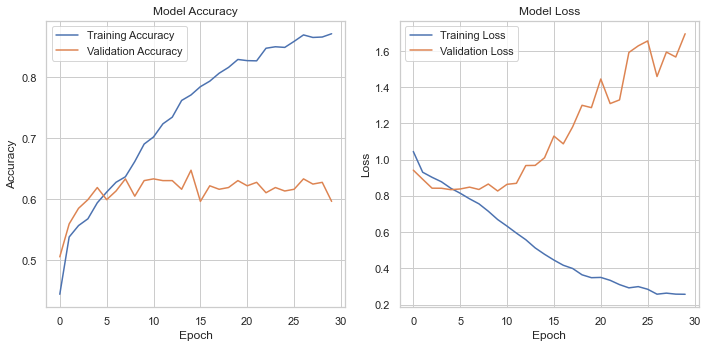

In [114]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create separate plots for accuracy and loss
plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(121)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(122)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

12/12 [==============================] - 1s 38ms/step - loss: 1.0112 - accuracy: 0.6417
Validation Accuracy: 0.6416666507720947
Precision: 0.34086204787371327
Recall: 0.3472222222222222
F1 Score: 0.3420621966794381


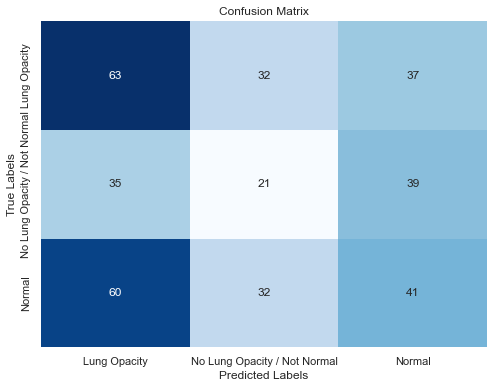

In [125]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score



# Evaluate the model_cnn256_3k on the validation dataset
val_loss, val_accuracy = model_cnn256_3k.evaluate(validation_generator, steps=12)
# Predict probabilities for the validation set
val_predictions = model_cnn256_3k.predict(validation_generator, steps=12)
# Convert probabilities to class labels
val_pred_labels = np.argmax(val_predictions, axis=1)
val_true_labels = validation_generator.classes
# Calculate precision, recall, and F1 score manually
precision = precision_score(val_true_labels, val_pred_labels, average='weighted')
recall = recall_score(val_true_labels, val_pred_labels, average='weighted')
f1 = f1_score(val_true_labels, val_pred_labels, average='weighted')


print("Validation Accuracy:", val_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



# Calculate confusion matrix
cm = confusion_matrix(val_true_labels, val_pred_labels)
# Class mapping provided
#class_mapping = val_generator.class_indices
class_mapping = {'Lung Opacity': 0, 'No Lung Opacity / Not Normal': 1, 'Normal': 2}
# Plot confusion matrix with numerical values and categorical labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


For more we can do transfer learning with existing models like resnet , vgg , yolo , mobile net for batter accuracy and identification through deep learning .
